In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import statsmodels.api as sm
import scipy.stats as stats
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import plotly.graph_objects as go

np.set_printoptions(suppress=True)

# Simulate Data

In [2]:
# Simulate data using scikit-learn
n_samples = 1000
n_features = 2
X, y, true_coefficients = make_regression(n_samples=n_samples, n_features=n_features, coef=True, noise=1.0, random_state=0)

In [3]:
# # Add normally distributed white noise to the dependent variable
# mn = 0
# sd = 1
# np.random.seed(0)
# e = np.random.normal(mn,sd,n_samples)
# y = y + e*10

# 1. Ordinary Least Squares (OLS) Method:

Derivation of the formula:

- https://economictheoryblog.com/2015/02/19/ols_estimator/
- https://humberanalytics.com/Using-OLS-to-fit-a-linear-line-to-noisy-data.html

![alternatvie text](https://s0.wp.com/latex.php?latex=y%3D+Xb+%2B%5Cepsilon+&bg=ffffff&fg=2b2b2b&s=0&c=20201002)

![alternatvie text](https://miro.medium.com/v2/resize:fit:720/1*F6abOBjEz-X-ZwgDIw3fVw.gif)

![alternatvie text](https://cdn-images-1.medium.com/max/498/1*Bt1LjOBnr9vkwPTotwM2yA.png)

## Calculation of model coefficients:

In [4]:
# Add intercept term to the data (Add a new column with ones for the intercept)
X_b = np.c_[np.ones((n_samples, 1)), X]

In [5]:
# Calculate the transpose matrix of X
X_b_transpose = X_b.T

In [6]:
# Calculate coefficients by hand
a = X_b_transpose.dot(X_b)
a_inverse = np.linalg.inv(a)
OLS_coefficients = a_inverse.dot(X_b_transpose).dot(y)

In [7]:
print("OLS Coefficients:", OLS_coefficients)

OLS Coefficients: [-0.04515316 41.06431679 40.09422036]


## Calculating Standard Errors:
The standard errors measure the variability of the estimated coefficients and indicate the precision of the estimates. The formula for calculating the standard error of a coefficient is:

$SE(β̂j) = √(MSE * Var(β̂j))$

Where:

- $SE(β̂j)$ is the standard error of the coefficient β̂j.
- $MSE$ is the Mean Squared Error, calculated as SSE / (n - p - 1), where SSE is the Sum of Squared Errors, n is the number of observations, and p is the number of predictors.
- $Var(β̂j)$ is the variance of the coefficient β̂j, which is the (j, j) element of the inverse of the matrix $(X^T * X)$

In [8]:
# Calculate residuals
residuals = y - X_b.dot(OLS_coefficients)

# Calculate the degrees of freedom
degrees_of_freedom = n_samples - n_features - 1

# Calculate standard errors for coefficients
MSE = np.sum(residuals ** 2) / degrees_of_freedom
standard_errors = np.sqrt(np.diagonal(np.linalg.inv(X_b_transpose.dot(X_b)) * MSE))
standard_errors


array([0.03015301, 0.03070767, 0.03093931])

The standard error (SE) of the coefficient estimate is a measure of the variability in the coefficient estimate. It quantifies the average amount of variation in the estimated coefficient. It considers the variability of the data, the complexity of the model (as reflected by the number of features), and the estimated variance of the error term.

## Calculating T-Statistic:

The t-statistic measures how many standard errors the estimated coefficient is away from zero. It's used to test whether the coefficient is significantly different from zero. The formula for calculating the t-statistic is:

$t = β̂j / SE(β̂j)$

Where:

- $t$ is the t-statistic for the coefficient $β̂j$.
- $β̂j$ is the estimated coefficient.
- $SE(β̂j)$ is the standard error of the coefficient $β̂j$.

In [9]:
# Calculate t-values and p-values
t_values = OLS_coefficients / standard_errors
t_values

array([  -1.49746738, 1337.26591798, 1295.89888656])

It is important to bear in mind that in the context of linear regression, when testing the significance of an individual coefficient, we are performing a **one-sample t-test**. This is because we are comparing the estimated coefficient (based on the sample data) to a hypothesized population parameter value (often the null hypothesis value, **which is typically zero for standard practice**). It makes sense, if the value of the coefficient on a population level equals zero, then this variable does not have an effect on the independent variable. 

A one-sample t-test compares the mean of a sample to a known value or hypothesized value, which is often referred to as the "null value." In linear regression, the estimated coefficient represents the average change in the dependent variable associated with a one-unit change in the predictor variable. The one-sample t-test assesses whether this average change is significantly different from the hypothesized population parameter value (often zero for testing the null hypothesis of no effect).

**NOTE**: In contrast, a two-sample t-test is used to compare the means of two separate groups (samples) to determine if they are significantly different from each other. This is not the same as the t-tests conducted in linear regression, which are focused on testing individual coefficients' significance.

Reference: https://vasishth.github.io/Freq_CogSci/hypothesis-testing-the-one-sample-t-test.html

## Calculating P-Value:

The p-value measures the probability of observing a t-statistic as extreme as the one calculated, assuming that the null hypothesis is true (i.e., the coefficient is zero). A small p-value suggests that the coefficient is statistically significant. The formula for calculating the p-value is based on the t-distribution:

$p = 2 * (1 - CDF_t(|t|, df))$

Where:

- $p$ is the p-value associated with the coefficient.
- $CDF_t$ is the cumulative distribution function of the t-distribution.
- $|t|$ is the absolute value of the t-statistic.
- $df$ is the degrees of freedom, which is $n - p - 1$.

In [10]:
p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=degrees_of_freedom))
p_values

array([0.1345882, 0.       , 0.       ])

## Final results

In [11]:
true_coefficients = np.insert(true_coefficients, 0, 0)

results_df = pd.DataFrame({
    'Independent Variables':['const', 'x1', 'x2'],
    'True Coefficients': true_coefficients,
    'OLS Coefficients': OLS_coefficients,
    'Standard Errors': standard_errors,
    't-Values': t_values,
    'p-Values': p_values
})
results_df

,Independent Variables,True Coefficients,OLS Coefficients,Standard Errors,t-Values,p-Values
0,const,0.000000,-0.045153,0.030153,-1.497467,0.134588
1,x1,41.091573,41.064317,0.030708,1337.265918,0.000000
2,x2,40.051046,40.094220,0.030939,1295.898887,0.000000


In [12]:
def regression_summary(coefficients:np.array, method:str) -> pd.DataFrame:
    
    # Calculate residuals
    residuals = y - X_b.dot(coefficients)

    # Calculate the degrees of freedom
    degrees_of_freedom = n_samples - n_features - 1

    # Calculate standard errors for coefficients
    MSE = np.sum(residuals ** 2) / degrees_of_freedom
    standard_errors = np.sqrt(np.diagonal(np.linalg.inv(X_b_transpose.dot(X_b)) * MSE))

    # Calculate t-values and p-values
    t_values = coefficients / standard_errors

    p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=degrees_of_freedom))

    # Summarise results
    results_df = pd.DataFrame({
        'Independent Variables':['const', 'x1', 'x2'],
        'True Coefficients': true_coefficients,
        f'{method} Coefficients': coefficients,
        'Standard Errors': standard_errors,
        't-Values': t_values,
        'p-Values': p_values
    })

    return results_df


_______________________

# OLS example with statsmodels API

In [13]:
model = sm.OLS(y,X_b)
results = model.fit()

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.710e+06
Date:                Sun, 20 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:28:56   Log-Likelihood:                -1369.5
No. Observations:                1000   AIC:                             2745.
Df Residuals:                     997   BIC:                             2760.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0452      0.030     -1.497      0.135      -0.104       0.014
x1            41.0643      0.031   1337.266      0.000      41.004      41.125
x2            40.0942      0.031   1295.899      0.000      40.034      40.155
==============================================================================
Omnibus:                        3.817   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.506
Skew:                          -0.088   Prob(JB):                        0.173
Kurtosis:                       2.769   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

________________

# 2. Gradient Descent Method:

Calculating the Gradient of the **MSE** Cost Function

Let's walk through the process of calculating the gradient of the cost function with respect to the coefficients $beta_0$ and $beta_1$ step by step:

*1. Define the Linear Regression Model:*

In linear regression, we have the model:
$$ Y = \beta_0 + \beta_1 \cdot X $$

*2. Define the Cost Function:*

The cost function measures the difference between our model's predictions and the actual target values. We use the Mean Squared Error (MSE) as the cost function:
$$ \text{MSE} = \frac{1}{2m} \sum_{i=1}^{m} (h_{\beta}(X_i) - Y_i)^2 $$

*3. Calculate the Gradient:*

We want to find the gradient of the cost function with respect to the coefficients $ beta_0 $ and $ beta_1 $. The gradient points in the direction of steepest increase of the function.

*Step 1: Calculate the Derivative with Respect to $ beta_0 $ :*
$$ \frac{\partial}{\partial \beta_0} \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (h_{\beta}(X_i) - Y_i) $$

*Step 2: Calculate the Derivative with Respect to $ beta_1 $:*
$$ \frac{\partial}{\partial \beta_1} \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (h_{\beta}(X_i) - Y_i) \cdot X_i $$

*4. Gradient Vector:*

The gradient vector combines the derivatives with respect to both coefficients:
$$ \nabla \text{MSE} = \left[ \frac{\partial}{\partial \beta_0} \text{MSE}, \frac{\partial}{\partial \beta_1} \text{MSE} \right] $$

*5. Using Matrix Notation:*

We can express the gradient vector in matrix notation using the data matrix \( X \) and the vector of errors \( h_{\beta}(X) - Y \):
$$ \nabla \text{MSE} = \frac{1}{m} X^T \cdot (X \cdot \beta - Y) $$

This matrix notation allows us to efficiently calculate the gradient using matrix operations, which is important for optimization algorithms like gradient descent.

In summary, by calculating the gradient of the cost function, we determine the direction and magnitude of the changes needed in the coefficients to minimize the cost and improve the fit of our linear regression model to the data.

### How do we get the matrix notation from step 5 above?

Let's break down the transformation from the gradient vector representation to the matrix notation step by step:

*1. Gradient Vector Representation:*
The gradient vector for the Mean Squared Error (MSE) cost function with respect to the coefficients $ beta_0 $ and $ beta_1 $ is given by:

$ \nabla \text{MSE} = \left[ \frac{\partial}{\partial \beta_0} \text{MSE}, \frac{\partial}{\partial \beta_1} \text{MSE} \right] $

*2. Step 1: Expand the Derivatives:*
Recall that:
- $ \frac{\partial}{\partial \beta_0} \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (h_{\beta}(X_i) - Y_i) $
- $ \frac{\partial}{\partial \beta_1} \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (h_{\beta}(X_i) - Y_i) \cdot X_i $

*3. Step 2: Combine the Derivatives into a Vector:*
Now we'll combine these derivatives into a vector form:
$$ \nabla \text{MSE} = \begin{bmatrix} \frac{1}{m} \sum_{i=1}^{m} (h_{\beta}(X_i) - Y_i) \\ \frac{1}{m} \sum_{i=1}^{m} (h_{\beta}(X_i) - Y_i) \cdot X_i \end{bmatrix} $$

*4. Step 3: Use Matrix Multiplication:*
Let \( X \cdot \beta \) denote the vector of predictions \( h_{\beta}(X) \) for all data points. The gradient vector becomes:
$$ \nabla \text{MSE} = \frac{1}{m} \begin{bmatrix} \sum_{i=1}^{m} (X_i \cdot \beta - Y_i) \\ \sum_{i=1}^{m} (X_i \cdot \beta - Y_i) \cdot X_i \end{bmatrix} $$

*5. Step 4: Further Simplification:*
We can express \( X \cdot \beta - Y \) as the residuals or errors of our predictions:
$$ X \cdot \beta - Y = \begin{bmatrix} (h_{\beta}(X_1) - Y_1) \\ (h_{\beta}(X_2) - Y_2) \\ \vdots \\ (h_{\beta}(X_m) - Y_m) \end{bmatrix} $$

*6. Step 5: Use Transpose for Matrix Multiplication:*
Now, use the transpose of the data matrix \( X \), denoted as \( X^T \), to perform the matrix multiplication:
$$ \nabla \text{MSE} = \frac{1}{m} X^T \begin{bmatrix} \sum_{i=1}^{m} \text{Error}i \\ \sum{i=1}^{m} \text{Error}_i \cdot X_i \end{bmatrix} $$

*7. Step 6: Combine Everything:*
Simplify the right-hand side to represent the full gradient vector:
$$ \nabla \text{MSE} = \frac{1}{m} X^T \cdot \begin{bmatrix} \text{Error}_1 \\ \text{Error}_2 \\ \vdots \\ \text{Error}_m \end{bmatrix} = \frac{1}{m} X^T \cdot (X \cdot \beta - Y) $$

And that's how we arrive at the matrix notation for the gradient of the cost function with respect to the coefficients in the context of linear regression! It's a more compact way of representing the calculations, leveraging matrix operations for efficiency.

In [15]:
# Hyperparameters
learning_rate = 0.01
num_iterations = 10_000

# Initialize coefficients
coefficients_gradient_descent = np.zeros(X_b.shape[1])
coefficients_gradient_descent

array([0., 0., 0.])

In [16]:
# Gradient Descent
for iteration in range(num_iterations):
    # Calculate predicted values
    predictions = X_b.dot(coefficients_gradient_descent)
    
    # Calculate residuals
    residuals = predictions - y
    
    # Calculate gradients
    gradients = (X_b.T.dot(residuals)) / n_samples
    
    # Update coefficients
    coefficients_gradient_descent -= learning_rate * gradients

In [17]:
gradient_descent_result = regression_summary(coefficients_gradient_descent, "Gradient Descent")
gradient_descent_result

,Independent Variables,True Coefficients,Gradient Descent Coefficients,Standard Errors,t-Values,p-Values
0,const,0.000000,-0.045153,0.030153,-1.497467,0.134588
1,x1,41.091573,41.064317,0.030708,1337.265918,0.000000
2,x2,40.051046,40.094220,0.030939,1295.898887,0.000000


# 3. Maximum Likelihood Estimation (MLE):

Reference: https://humberanalytics.com/Using-the-Maximum-Likelihood-Estimation-(MLE)-to-determine-a-linear-line-of-best-fit-to-noisy-data.html

Remember that one of the assumptions in linear regression is that **residuals should be normally distributed**. Note that 

Using the log-likelihood function for the normal distribution:

$$ ln \left( L(\mu_{i}, \sigma^{2}|y_{i}) \right) = - \frac{n}{2} ln \left( 2\pi \right) - \frac{n}{2} ln \left( \sigma ^{2} \right) -  {\frac{\sum_{i}^{n}\left ( y_{i} -\mu_{i}  \right )^{2}}{2\sigma ^{2}}} $$

We know that: $\sum_{i}^{n}\left ( y_{i} -\mu_{i}  \right )^{2} = (y-X\beta)^{T}(y-X\beta)$

We are trying to find the parameters which define the distribution from which the residuals are sampled from, by maximising the (log) likelihood value. Remember that residuals are the differences between the measured data and the estimated values predicted using our model.

$$ ln \left( L(\mu_{i}, \sigma^{2}|y_{i}) \right) = - \frac{n}{2} ln \left( 2\pi \right) - \frac{n}{2} ln \left( \sigma ^{2} \right) - {\frac{(y-X\beta)^{T}(y-X\beta)}{2\sigma ^{2}}}$$

Shapiro test of nornality: ShapiroResult(statistic=0.9981397390365601, pvalue=0.3461662828922272)
****************************************
Kolmogorov Smirnov test of nornality: KstestResult(statistic=0.020271275293872626, pvalue=0.7978579782548385, statistic_location=0.7578470523558352, statistic_sign=1)
****************************************


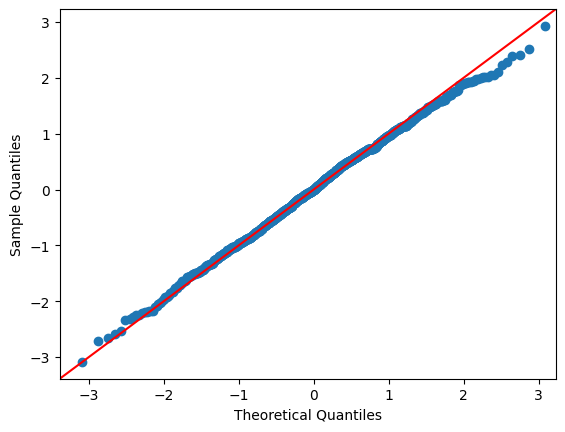

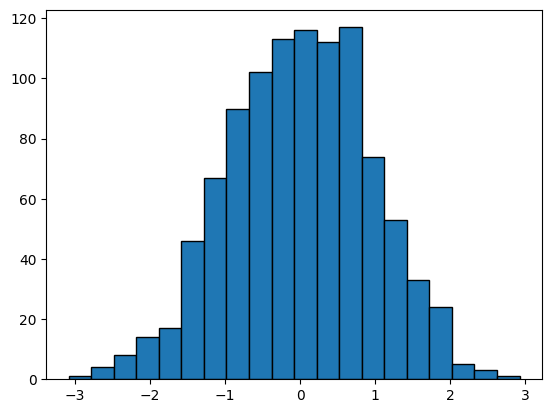

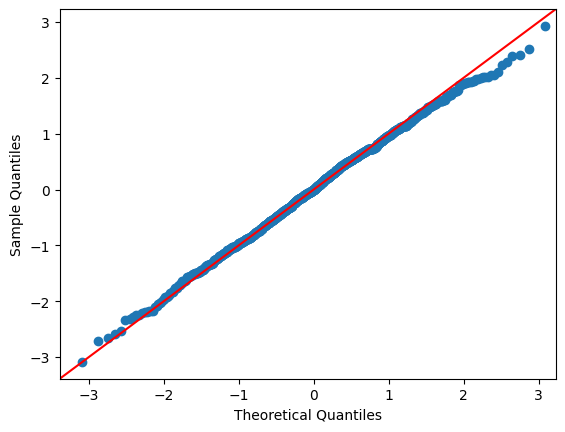

In [18]:
y_pred = X_b.dot(OLS_coefficients)
residuals = y - y_pred

print(f"Shapiro test of nornality: {stats.shapiro(residuals)}")
print("****"*10)
print(f"Kolmogorov Smirnov test of nornality: {stats.kstest(residuals, 'norm')}")
print("****"*10)
plt.hist(residuals, edgecolor='black', bins=20)
sm.qqplot(residuals, line ='45')

In [19]:
def nloglikelihood(params, X, y):
    beta0, beta1, beta2, var = params # give the array elements a name to use later in the function
    n = len(y)
    ll1 = -(n/2)*np.log(2*math.pi)
    ll2 = -(n/2)*np.log(var)
    
    # create the beta vector
    B = np.array([beta0, beta1, beta2]).T
    ll3 = - ((y - X.dot(B)).T).dot(y - X.dot(B))/(2*var)
    return -(ll1 + ll2 + ll3) # factor by -1 so we can minimise this function

In [20]:
# add some bounds to beta0, beta1 and sigma^2
bnds = ((None, None), (None, None), (None, None), (None, None))

# minimise the function
res = minimize(nloglikelihood, [1,1,1,1], args=(X_b,y), method='L-BFGS-B', bounds=bnds)
coefficients_MLE = res.x[:-1]
variance_coefficients = res.x[-1]
coefficients_MLE

C:\Users\FI40WR\AppData\Local\Temp\ipykernel_5720\3832414271.py:5: RuntimeWarning: invalid value encountered in log
  ll2 = -(n/2)*np.log(var)


array([-0.61348863, 40.00471438, 38.75148286])

In [21]:
MLE_result = regression_summary(coefficients_MLE, "MLE")
MLE_result

,Independent Variables,True Coefficients,MLE Coefficients,Standard Errors,t-Values,p-Values
0,const,0.000000,-0.613489,0.062894,-9.754351,0.0
1,x1,41.091573,40.004714,0.064051,624.578357,0.0
2,x2,40.051046,38.751483,0.064534,600.482357,0.0


# 4. Comparison:

In [22]:
results_df

,Independent Variables,True Coefficients,OLS Coefficients,Standard Errors,t-Values,p-Values
0,const,0.000000,-0.045153,0.030153,-1.497467,0.134588
1,x1,41.091573,41.064317,0.030708,1337.265918,0.000000
2,x2,40.051046,40.094220,0.030939,1295.898887,0.000000


In [23]:
gradient_descent_result

,Independent Variables,True Coefficients,Gradient Descent Coefficients,Standard Errors,t-Values,p-Values
0,const,0.000000,-0.045153,0.030153,-1.497467,0.134588
1,x1,41.091573,41.064317,0.030708,1337.265918,0.000000
2,x2,40.051046,40.094220,0.030939,1295.898887,0.000000


In [24]:
MLE_result

,Independent Variables,True Coefficients,MLE Coefficients,Standard Errors,t-Values,p-Values
0,const,0.000000,-0.613489,0.062894,-9.754351,0.0
1,x1,41.091573,40.004714,0.064051,624.578357,0.0
2,x2,40.051046,38.751483,0.064534,600.482357,0.0


In [35]:
# Create a mesh grid for plotting the regression plane
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)
X_mesh, Y_mesh = np.meshgrid(x_range, y_range)

# Calculate predicted values for the mesh grid using the linear regression equation
predicted_mesh_OLS = results_df.iloc[:, 2][0] + results_df.iloc[:, 2][1] * X_mesh + results_df.iloc[:, 2][2] * Y_mesh
predicted_mesh_gradient_descent = gradient_descent_result.iloc[:, 2][0] + gradient_descent_result.iloc[:, 2][1] * X_mesh + gradient_descent_result.iloc[:, 2][2] * Y_mesh
predicted_mesh_MLE = MLE_result.iloc[:, 2][0] + MLE_result.iloc[:, 2][1] * X_mesh + MLE_result.iloc[:, 2][2] * Y_mesh

# Create a 3D plot using Plotly
fig = go.Figure()

# Scatter plot of the actual data
fig.add_trace(go.Scatter3d(x=X[:, 0], y=X[:, 1], z=y, mode='markers', marker=dict(color='blue'), name='Actual Data'))

# Plot the regression planes
fig.add_trace(go.Surface(x=X_mesh, y=Y_mesh, z=predicted_mesh_OLS, opacity=0.5, name='OLS Regression Plane', showlegend=True))
fig.add_trace(go.Surface(x=X_mesh, y=Y_mesh, z=predicted_mesh_gradient_descent, opacity=0.5, name='Gradient Descent Regression Plane', showlegend=True))
fig.add_trace(go.Surface(x=X_mesh, y=Y_mesh, z=predicted_mesh_MLE, opacity=0.5, name='MLE Regression Plane', showlegend=True))

# Set labels for axes
fig.update_layout(scene=dict(xaxis_title='X1', yaxis_title='X2', zaxis_title='y'))

fig.update_layout(width = 1000, height = 800)
    
# Set title and legend
fig.update_layout(title='Linear Regression with Two Independent Variables')

# Show the plot
fig.show()

End